# Explore LHC dataset

In [1]:
%matplotlib inline

import sys
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import corner
import logging
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

logging.basicConfig(
    format="%(asctime)-5.5s %(name)-30.30s %(levelname)-7.7s %(message)s",
    datefmt="%H:%M",
    level=logging.INFO,
)

sys.path.append("../../")
from experiments.datasets import WBFLoader, WBF40DLoader


## Get data

In [2]:
n = 100000

In [3]:
sim = WBFLoader()
sim40d = WBF40DLoader()

sim.latent_dim(), sim40d.latent_dim()

(14, 14)

In [4]:
x, params = sim.load_dataset(train=True, dataset_dir="../data/samples/lhc", numpy=True, limit_samplesize=n)
x_ = sim._preprocess(x, inverse=True)
x_noise = np.random.normal(size=x.shape)


10:03 experiments.datasets.collider  INFO    Only using 100000 of 1000000 available samples


In [5]:
x40d, _ = sim40d.load_dataset(train=True, dataset_dir="../data/samples/lhc40d", numpy=True, limit_samplesize=n)
x40d_noise = np.random.normal(size=x40d.shape)


10:03 experiments.datasets.collider  INFO    Only using 100000 of 1000000 available samples


In [6]:
x40d_test, _ = sim40d.load_dataset(train=False, dataset_dir="../data/samples/lhc40d", numpy=True, limit_samplesize=n)
x40d_model = np.load("../data/results/mf_14_lhc40d_sequential_may_samples.npy")

10:03 experiments.datasets.collider  INFO    Only using 100000 of 10000 available samples


## PCA

In [ ]:
pca = PCA(n_components=48)
pca.fit(x)

explained_var = pca.explained_variance_ratio_


In [ ]:
plt.figure(figsize=(5,5))

plt.plot(np.arange(1, 48.5), explained_var, ls=" ", marker="o", ms=5.)

plt.ylim(0.,None)
plt.xlabel("PCA component")
plt.ylabel("Explained variance ratio")

plt.tight_layout()
plt.show()


In [ ]:
np.sum(explained_var[:14])

## t-SNE

In [ ]:
x_tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000).fit_transform(x)
noise_tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000).fit_transform(x_noise)


In [ ]:
x_reshuffled = np.copy(x)
idx = np.random.rand(*x_reshuffled.shape).argsort(0)
x_reshuffled = x_reshuffled[idx, np.arange(x_reshuffled.shape[1])]

x_reshuffled_tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000).fit_transform(x_reshuffled)


In [ ]:
plt.figure(figsize=(12, 4))

ax = plt.subplot(1,3,1)
plt.scatter(
    x_tsne[x[:,16]>0.][:, 0],
    x_tsne[x[:,16]>0.][:, 1],
    s=12.0,
    alpha=0.15,
    c="C0"
)
plt.scatter(
    x_tsne[x[:,16]<0.][:, 0],
    x_tsne[x[:,16]<0.][:, 1],
    s=12.0,
    alpha=0.15,
    c="C1"
)
plt.xlabel("t-SNE component 0")
plt.ylabel("t-SNE component 1")

ax = plt.subplot(1,3,2)
plt.scatter(
    x_reshuffled_tsne[:, 0],
    x_reshuffled_tsne[:, 1],
    s=12.0,
    alpha=0.15,
    c="C2"
)
plt.xlabel("t-SNE component 0")
plt.ylabel("t-SNE component 1")

ax = plt.subplot(1,3,3)
plt.scatter(
    noise_tsne[:, 0],
    noise_tsne[:, 1],
    s=12.0,
    alpha=0.15,
    c="C4"
)
plt.xlabel("t-SNE component 0")
plt.ylabel("t-SNE component 1")

plt.tight_layout()
plt.savefig("../figures/lhc_tsne.pdf")

In [ ]:
npanels = 48
ncols = 6
nrows = (npanels - 1) // ncols + 1

plt.figure(figsize=(ncols * 3, nrows * 3))

for i in range(npanels):
    ax = plt.subplot(nrows,ncols,i+1)
    plt.scatter(
        x_tsne[x[:,i]>0.][:250, 0],
        x_tsne[x[:,i]>0.][:250, 1],
        s=12.0,
        c="C0"
    )
    plt.scatter(
        x_tsne[x[:,i]<0.][:250, 0],
        x_tsne[x[:,i]<0.][:250, 1],
        s=12.0,
        c="C1"
    )
    plt.title("Feature {}".format(i))
    plt.xlabel("t-SNE 0")
    plt.ylabel("t-SNE 1")

plt.tight_layout()
plt.savefig("../figures/lhc_tsne_features.pdf")

## Determine weights for individual closure tests

In [ ]:
random_closure_tests = np.mean(sim._closure_tests(x_noise), axis=1)
CLOSURE_TEST_WEIGHTS = 1. / random_closure_tests
print(", ".join([str(w) for w in CLOSURE_TEST_WEIGHTS]))

## Closure test vs noise

In [ ]:
np.mean(sim.distance_from_manifold(x)), np.mean(sim.distance_from_manifold(x_noise))

In [ ]:
np.mean(sim40d.distance_from_manifold(x40d)), np.mean(sim40d.distance_from_manifold(x40d_noise))

In [ ]:
noises = np.geomspace(1.e-9, 1., 100)

closure = []

for noise in noises:
    closure.append(np.mean(sim.distance_from_manifold(x + noise * np.random.normal(size=x.shape))))

In [ ]:
plt.figure(figsize=(5,5))

plt.plot(noises, closure)

plt.xscale("log")
plt.yscale("log")

plt.xlabel("Noise")
plt.ylabel("Mean closure")

plt.tight_layout()
plt.savefig("../figures/lhc_closure_vs_noise.pdf")


## Histograms of 40D data

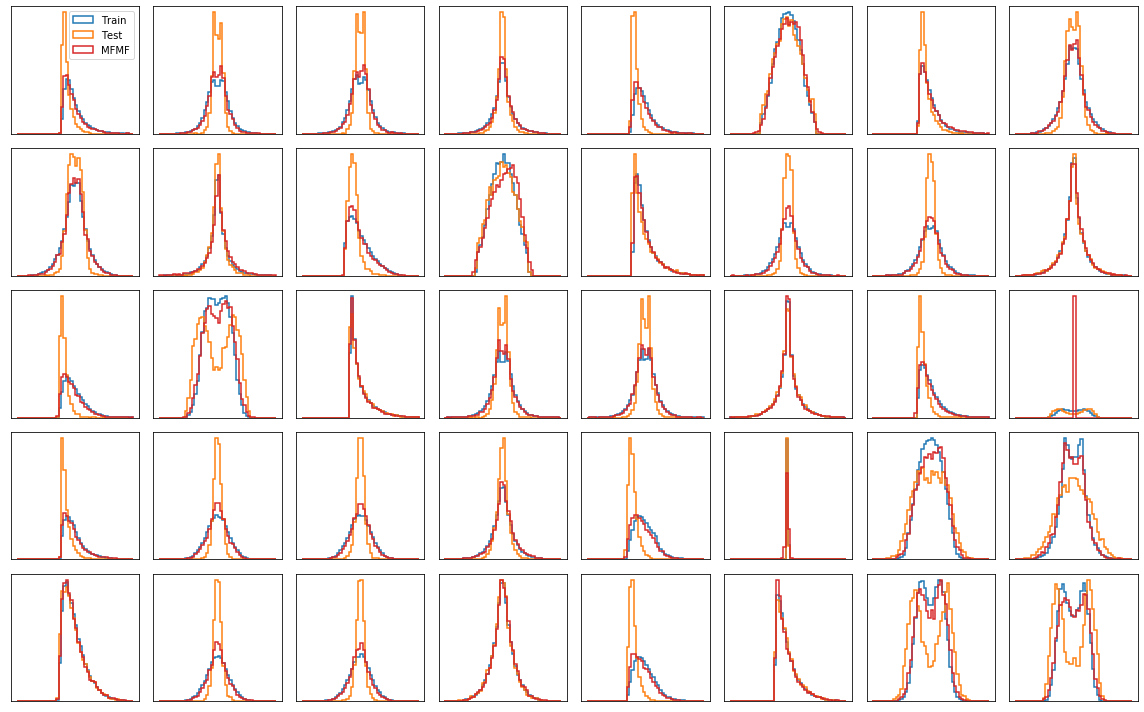

In [11]:
ncols = 8
nrows = 5

fig = plt.figure(figsize=(2*ncols, 2*nrows))

for i in range(40):
    ax = plt.subplot(nrows, ncols, i+1)
    plt.hist(
        x40d[:,i], range=(-5,5), bins=50, density=True,
        histtype="step", color="C0", ls="-", lw=1.5, label="Train"
    )
    plt.hist(
        x40d_test[:,i], range=(-5,5), bins=50, density=True,
        histtype="step", color="C1", ls="-", lw=1.5, label="Test"
    )
    plt.hist(
        x40d_model[:,i], range=(-5,5), bins=50, density=True,
        histtype="step", color="C3", ls="-", lw=1.5, label="MFMF"
    )
    
    if i == 0:
        plt.legend()
    
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    
plt.tight_layout()
plt.savefig("../figures/lhc_features_histos.pdf")


## Scatter plots of 40D data

In [10]:
features = list(range(40))
n = len(features)
m = 200

fig = plt.figure(figsize=(2*(n-1), 2*(n-1)))
for ip, i in enumerate(features[1:]):
    for jp in range(ip):
        j = features[jp]
        ax = plt.subplot(n-1, n-1, ip*(n-1) + jp + 1)
        plt.scatter(x40d[:m,j], x40d[:m,i], s=4., c="C0", rasterized=True)
        plt.scatter(x40d_test[:m,j], x40d_test[:m,i], s=4., c="C1", rasterized=True)
        plt.scatter(x40d_model[:m,j], x40d_model[:m,i], s=4., c="C3", rasterized=True)
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        plt.xlim(-2.5,2.5)
        plt.ylim(-2.5,2.5)
        
        if ip == n - 2:
            plt.xlabel(str(j))
        if jp == 0:
            plt.ylabel(str(i))
        
plt.tight_layout()
plt.savefig("../figures/lhc_features_40d.pdf")


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


## Scatter plots of 48D data

In [ ]:
features = [0,1,2,3,7,8,9,10, 14,15,16,17, 21,22,23,24]
n = len(features)

fig = plt.figure(figsize=(2*(n-1), 2*(n-1)))
for ip, i in enumerate(features[1:]):
    print(ip, i)
    for jp in range(ip):
        j = features[jp]
        ax = plt.subplot(n-1, n-1, ip*(n-1) + jp + 1)
        plt.scatter(x[:500,j], x[:500,i], s=4., rasterized=True)
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        plt.xlim(-2.5,2.5)
        plt.ylim(-2.5,2.5)
        
        if ip == n - 2:
            plt.xlabel(str(j))
        if jp == 0:
            plt.ylabel(str(i))
        
plt.tight_layout()
plt.savefig("../figures/lhc_features_independent.pdf")


In [ ]:
features = [0,1,2,3,7,8,9,10, 14,15,16,17, 21,22,23,24]
nx = len(features)
ny = 48 - nx

fig = plt.figure(figsize=(2*nx, 2*ny))
for ip, i in enumerate(features):
    jp = 0
    for j in range(48):
        if j in features:
            continue
        
        ax = plt.subplot(ny, nx, jp*n + ip + 1)
        plt.scatter(x[:500,i], x[:500,j], s=4., rasterized=True)
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        plt.xlim(-2.5,2.5)
        plt.ylim(-2.5,2.5)
        
        if jp == ny - 1:
            plt.xlabel(str(i))
        if ip == 0:
            plt.ylabel(str(j))
        
        jp += 1
        
plt.tight_layout()
plt.savefig("../figures/lhc_features_derived_vs_independent.pdf")


In [ ]:
features = [0,1,2,3,7,8,9,10, 14,15,16,17, 21,22,23,24]
n = 48 - len(features)

fig = plt.figure(figsize=(2*(n-1), 2*(n-1)))
ip = 0
for i in range(48):
    if i in features:
        continue
        
    jp = 0
    for j in range(i):
        if j in features:
            continue
        
        ax = plt.subplot(n-1, n-1, ip*(n-1) + jp + 1)
        plt.scatter(x[:500,j], x[:500,i], s=4., rasterized=True)
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        plt.xlim(-2.5,2.5)
        plt.ylim(-2.5,2.5)
        
        if ip == n - 2:
            plt.xlabel(str(j))
        if jp == 0:
            plt.ylabel(str(i))
            
        jp += 1
    
    if jp > 0:
        ip += 1
        
plt.tight_layout()
plt.savefig("../figures/lhc_features_derived.pdf")


In [ ]:
'''
0 e_a1
1 px_a1
2 py_a1
3 pz_a1
4 pt_a1
5 eta_a1
6 phi_a1
7 e_a2
8 px_a2
9 py_a2
10 pz_a2
11 pt_a2
12 eta_a2
13 phi_a2
14 e_j1
15 px_j1
16 py_j1
17 pz_j1
18 pt_j1
19 eta_j1
20 phi_j1
21 e_j2
22 px_j2
23 py_j2
24 pz_j2
25 pt_j2
26 eta_j2
27 phi_j2
28 e_aa
29 px_aa
30 py_aa
31 pz_aa
32 pt_aa
33 m_aa
34 eta_aa
35 phi_aa
36 deltaeta_aa
37 deltaphi_aa
38 e_jj
39 px_jj
40 py_jj
41 pz_jj
42 pt_jj
43 m_jj
44 eta_jj
45 phi_jj
46 deltaeta_jj
47 deltaphi_jj
'''